## Import Libs

In [1]:
import os
import random
import gc
import time
import copy
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn.functional as F
from torch import nn
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler, CosineAnnealingLR
import timm

from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from collections import defaultdict
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, roc_auc_score

import warnings # 避免一些可以忽略的报错
warnings.filterwarnings('ignore')
# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
sr_ = Style.RESET_ALL

/data1/hjs/anaconda3/envs/transformers/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## CONFIG

In [2]:
is_debug = False
use_803098 = False
use_401059_val = True
use_1977_train = False # 2024_0 + 2024_1 + 2020_1
use_1954_train = True # 2024_0 + 2024_1 + 2020_1
use_10999_train = False # 2024_0 + 2024_1 + 2020_1 + 2019_1
use_401059_train = False # 2024_0 + 2024_1

class CONFIG:
    seed = 308
    epochs = 8 if not is_debug else 2
    
    train_batch_size = 32
    valid_batch_size = 512
    img_size = [[160, 160],
                [160, 160]]
    now_cv = 0
    n_classes = 1
    n_folds = 5
    
    n_accumulate = 1.0
    n_workers = os.cpu_count()
    
    formatted_time = None
    ckpt_save_path = None

    learning_rate = 1e-3 * train_batch_size * n_accumulate / 32
    # learning_rate = 1e-5 * train_batch_size / 32 # eva02
    total_sample = 1954
    T_max = [1586 * epochs / train_batch_size // n_accumulate,
             1522 * epochs / train_batch_size // n_accumulate,
             1582 * epochs / train_batch_size // n_accumulate,
             1574 * epochs / train_batch_size // n_accumulate,
             1552 * epochs / train_batch_size // n_accumulate] # 401059
    min_lr = 1e-6
    weight_decay = 1e-6
    scheduler = "CosineAnnealingWithWarmupLR" # 'CosineAnnealingLR'
    DataParallel = True

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    """
    tf_efficientnet_b0_ns
    convnext_atto_ols.a2_in1k
    tiny_vit_21m_512.dist_in22k_ft_in1k
    eva02_base_patch14_224.mim_in22k
    tf_efficientnetv2_s.in21k_ft_in1k
    tf_efficientnetv2_l.in21k_ft_in1k
    tf_efficientnetv2_b3.in21k_ft_in1k
    tf_efficientnet_b3.ns_jft_in1k
    convnextv2_tiny.fcmae_ft_in22k_in1k_384
    convnext_tiny.fb_in22k_ft_in1k_384

    efficientvit_b0.r224_in1k
    efficientvit_b3.r256_in1k

    edgenext_base.in21k_ft_in1k
    eca_nfnet_l0.ra2_in1k
    """
    model_name = "ensemble_linear"
    model_names = ["tf_efficientnetv2_s.in21k_ft_in1k",
                   "edgenext_base.in21k_ft_in1k",
                   "convnext_atto_ols.a2_in1k",
                   "tf_efficientnet_b3.ns_jft_in1k"]
    ckpt_path = ["/data1/hjs/pythonProject/pythonProject/ISIC2024/output/2024-09-03_12:17:57_tf_efficientnetv2_s.in21k_ft_in1k_output",
                 "/data1/hjs/pythonProject/pythonProject/ISIC2024/output/2024-08-27_13:27:06_edgenext_base.in21k_ft_in1k_output",
                 "/data1/hjs/pythonProject/pythonProject/ISIC2024/output/2024-08-29_13:16:10_convnext_atto_ols.a2_in1k_output",
                 "/data1/hjs/pythonProject/pythonProject/ISIC2024/output/2024-08-29_01:58:41_tf_efficientnet_b3.ns_jft_in1k_output"]
    is_pretrained = False
    backbone_grad = True
    use_gempool = False
    smooth_threshold = 0.05

    old_my_train_csv = "/data1/hjs/pythonProject/pythonProject/ISIC2024/my_train_with_sgkfold.csv"
    my_train_csv = "/data1/hjs/pythonProject/pythonProject/ISIC2024/my_train_with_sgkfold.csv"
    train_img_dir = "/data1/hjs/pythonProject/pythonProject/ISIC2024/image"
    new_train_img_dir = "/data1/hjs/pythonProject/pythonProject/ISIC2024/new_1_imgs"
    train_1954_csv = "/data1/hjs/pythonProject/pythonProject/ISIC2024/train_1954.csv"
    train_1977_csv = "/data1/hjs/pythonProject/pythonProject/ISIC2024/train_1977.csv"
    train_793_csv = "/data1/hjs/pythonProject/pythonProject/ISIC2024/train_793.csv"
    train_10999_csv = "/data1/hjs/pythonProject/pythonProject/ISIC2024/train_10999.csv"

if CONFIG.DataParallel:
    os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
    print("IN DataParallel!")
else:
    os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
    print("NO IN DataParallel!")

IN DataParallel!


## Set Random Seed

In [3]:
def set_seed(seed=308):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
set_seed(CONFIG.seed)

## Data Progress

In [4]:
# root_dir = "/kaggle/input/isic-2024-challenge/train-image/image"
# img_ids = os.listdir(root_dir)

# min_size = 9999
# max_size = 0
# n_0_64 = 0
# n_64_96 = 0
# n_96_160 = 0
# n_160_224 = 0
# n_224_269 = 0
# for img_id in tqdm(img_ids):
#     path = os.path.join(root_dir, img_id)
#     a = Image.open(path)
#     s = np.array(a).shape[0]
#     if s > max_size:
#         max_size = s
#     if s < min_size:
#         min_size = s
        
#     if s >= 0 and s < 64:
#         n_0_64 += 1
#     elif s >= 64 and s < 96:
#         n_64_96 += 1
#     elif s >= 96 and s < 160:
#         n_96_160 += 1
#     elif s >= 160 and s < 224:
#         n_160_224 += 1
#     elif s >= 224:
#         n_224_269 += 1
        
# print(f"max_size : {max_size}") # max_size : 269
# print(f"min_size : {min_size}") # min_size : 41

# print(f"n_0_64    : {n_0_64}")    # 86
# print(f"n_64_96   : {n_64_96}")   # 3461
# print(f"n_96_160  : {n_96_160}")  # 368914
# print(f"n_160_224 : {n_160_224}") # 28305
# print(f"n_224_269 : {n_224_269}") # 293

# """
# 以上代码运行时间 : 37:20
# """

In [5]:
if os.path.exists(CONFIG.my_train_csv):
    train = pd.read_csv(CONFIG.my_train_csv)
else:
    train = pd.read_csv(CONFIG.train_csv)

valid = pd.read_csv(CONFIG.old_my_train_csv)
train

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,kfold
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282,4
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455,0
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040,0
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998,2
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401054,ISIC_9999937,0,IP_1140263,70.0,male,anterior torso,6.80,TBP tile: close-up,3D: XP,22.574335,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999988,4
401055,ISIC_9999951,0,IP_5678181,60.0,male,posterior torso,3.11,TBP tile: close-up,3D: white,19.977640,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999820,1
401056,ISIC_9999960,0,IP_0076153,65.0,female,anterior torso,2.05,TBP tile: close-up,3D: XP,17.332567,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999416,2
401057,ISIC_9999964,0,IP_5231513,30.0,female,anterior torso,2.80,TBP tile: close-up,3D: XP,22.288570,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,0


In [6]:
if not os.path.exists(CONFIG.my_train_csv):
    print("贴 KFold....")
    # # 设置StratifiedKFold参数
    # skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=308)

    # # 创建一个新的列来保存KFold标签
    # train['kfold'] = -1

    # # 遍历每个fold并分配标签
    # for fold, (train_idx, val_idx) in enumerate(skf.split(train, train['target'])):
    #     train.loc[val_idx, 'kfold'] = fold
train

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,kfold
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282,4
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455,0
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040,0
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998,2
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401054,ISIC_9999937,0,IP_1140263,70.0,male,anterior torso,6.80,TBP tile: close-up,3D: XP,22.574335,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999988,4
401055,ISIC_9999951,0,IP_5678181,60.0,male,posterior torso,3.11,TBP tile: close-up,3D: white,19.977640,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999820,1
401056,ISIC_9999960,0,IP_0076153,65.0,female,anterior torso,2.05,TBP tile: close-up,3D: XP,17.332567,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999416,2
401057,ISIC_9999964,0,IP_5231513,30.0,female,anterior torso,2.80,TBP tile: close-up,3D: XP,22.288570,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,0


In [7]:
if use_803098:
    new_train = train
else:
    if use_1954_train:
        new_train = pd.read_csv(CONFIG.train_1954_csv)
    elif use_1977_train:
        new_train = pd.read_csv(CONFIG.train_1977_csv)
    elif use_10999_train:
        new_train = pd.read_csv(CONFIG.train_10999_csv)
    elif use_401059_train:
        new_train = pd.read_csv(CONFIG.my_train_csv)
    else:
        new_train = pd.read_csv(CONFIG.train_793_csv)
    # train_0 = train[train["target"] != 1] # 400666 rows × 56 columns
    # train_1 = train[train["target"] == 1] # 393 rows × 56 columns

    # train_0 = train_0.reset_index(drop=True)
    # train_1 = train_1.reset_index(drop=True)

    # # train_1[train_1["kfold"] == 4] # [78, 79, 79, 79, 78] sum --> 393

    # # 0 : 1 ---> 1020 : 1

    # # 每个 fold 取 80 个样本 总共 400
    # some_train_0 = []
    # for fold in range(CONFIG.n_folds):
    #     _tmp = train_0[train_0["kfold"] == fold].reset_index(drop=True).iloc[:200, :]
    #     some_train_0.append(_tmp)

    # some_train_0 = pd.concat(some_train_0).reset_index(drop=True)
    # some_train_0

    # new_train = pd.concat([some_train_0, train_1]).reset_index(drop=True)
    # new_train = pd.concat([new_train, train_1_2020]).reset_index(drop=True)
    # new_train = new_train.sample(frac=1).reset_index(drop=True)
new_train

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,kfold
0,ISIC_6249729,1,IP_0973797,65.0,male,anterior torso,1.74,TBP tile: close-up,3D: XP,23.844375,...,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Superficial",NaN,NaN,NaN,99.999332,0
1,ISIC_0091081,0,IP_4414342,40.0,female,posterior torso,2.63,TBP tile: close-up,3D: XP,24.385464,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999452,2
2,ISIC_9963177,1,IP_1165806,70.0,male,torso,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
3,ISIC_0092262,0,IP_8078890,80.0,male,head/neck,4.04,TBP tile: close-up,3D: white,17.336060,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,81.093390,1
4,ISIC_6025411,1,IP_3631110,45.0,male,head/neck,3.66,TBP tile: close-up,3D: XP,22.511600,...,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,98.159915,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1949,ISIC_0429895,1,IP_1045174,65.0,male,head/neck,3.15,TBP tile: close-up,3D: white,11.582197,...,Malignant::Malignant epidermal proliferations:...,Malignant,Malignant epidermal proliferations,"Squamous cell carcinoma, Invasive",NaN,NaN,NaN,NaN,0.000002,3
1950,ISIC_0084802,0,IP_3921915,50.0,male,anterior torso,8.20,TBP tile: close-up,3D: XP,24.091715,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,98.759043,0
1951,ISIC_4495069,1,IP_9324599,85.0,male,posterior torso,8.54,TBP tile: close-up,3D: white,16.806420,...,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,50.681180,4
1952,ISIC_2439617,1,IP_8977835,80.0,male,anterior torso,7.40,TBP tile: close-up,3D: white,21.430380,...,Malignant::Malignant melanocytic proliferation...,Malignant,Malignant melanocytic proliferations (Melanoma),Melanoma in situ,"Melanoma in situ, Lentigo maligna type",NaN,NaN,NaN,99.999960,4


## Dataset and DataLoader

In [8]:
# class HairAugmentation(A.ImageOnlyTransform):
#     def __init__(self, num_hairs=5, hair_color=(0, 0, 0), always_apply=False, p=0.5):
#         super(HairAugmentation, self).__init__(always_apply, p)
#         self.num_hairs = num_hairs
#         self.hair_color = hair_color

#     def apply(self, img, **params):
#         img = img.copy()
#         h, w, _ = img.shape
        
#         for _ in range(self.num_hairs):
#             # Randomly choose the position and size of the hair
#             x1, y1 = random.randint(0, w), random.randint(0, h)
#             x2, y2 = random.randint(0, w), random.randint(0, h)
#             thickness = random.randint(1, 1)  # Making the hair thinner
#             img = cv2.line(img, (x1, y1), (x2, y2), self.hair_color, thickness)
        
#         return img

#     def get_params_dependent_on_targets(self, params):
#         return {}

#     def get_transform_init_args_names(self):
#         return ("num_hairs", "hair_color")
    
# # HairAugmentation(num_hairs=10, hair_color=(0, 0, 0), p=1.0),

class HairAugmentation(A.ImageOnlyTransform):
    def __init__(self, num_hairs_range=(5, 15), hair_color_range=((0, 0, 0), (255, 255, 255)), always_apply=False, p=0.5):
        super(HairAugmentation, self).__init__(always_apply, p)
        self.num_hairs_range = num_hairs_range
        self.hair_color_range = hair_color_range

    def apply(self, img, **params):
        img = img.copy()
        h, w, _ = img.shape

        num_hairs = random.randint(self.num_hairs_range[0], self.num_hairs_range[1])
        hair_color = (
            random.randint(self.hair_color_range[0][0], self.hair_color_range[1][0]),
            random.randint(self.hair_color_range[0][1], self.hair_color_range[1][1]),
            random.randint(self.hair_color_range[0][2], self.hair_color_range[1][2])
        )

        for _ in range(num_hairs):
            # Randomly choose the position and size of the hair
            x1, y1 = random.randint(0, w), random.randint(0, h)
            x2, y2 = random.randint(0, w), random.randint(0, h)
            thickness = random.randint(1, 1)  # Making the hair thinner
            img = cv2.line(img, (x1, y1), (x2, y2), hair_color, thickness)

        return img

    def get_params_dependent_on_targets(self, params):
        return {}

    def get_transform_init_args_names(self):
        return ("num_hairs_range", "hair_color_range")
    
# HairAugmentation(num_hairs_range=(5, 15), hair_color_range=((0, 0, 0), (255, 255, 255)), p=1.0)

In [9]:
def transform(img, img_size):
    composition = A.Compose([
        A.Resize(img_size[0], img_size[1]),
        A.Normalize(),
        ToTensorV2(),
    ])
    return composition(image=img)["image"]

# def transform_train(img):
#     composition = A.Compose([
#         A.Resize(CONFIG.img_size[0], CONFIG.img_size[1]),
#         HairAugmentation(num_hairs_range=(5, 15), hair_color_range=((0, 0, 0), (255, 255, 255)), p=0.5),
#         ToTensorV2(),
#     ])
#     return composition(image=img)["image"]


# def transform_val(img):
#     composition = A.Compose([
#         A.Resize(CONFIG.img_size[0], CONFIG.img_size[1]),
#         ToTensorV2(),
#     ])
#     return composition(image=img)["image"]

# def transform_train(img):
#     composition = A.Compose([
#         HairAugmentation(num_hairs_range=(5, 15), hair_color_range=((0, 0, 0), (255, 255, 255)), p=0.5),
#         A.Transpose(p=0.5),
#         A.VerticalFlip(p=0.5),
#         A.HorizontalFlip(p=0.5),
#         A.RandomBrightness(limit=0.2, p=0.75),
#         A.RandomContrast(limit=0.2, p=0.75),
#         A.OneOf([
#             A.MotionBlur(blur_limit=5),
#             A.MedianBlur(blur_limit=5),
#             A.GaussianBlur(blur_limit=5),
#             A.GaussNoise(var_limit=(5.0, 30.0)),
#         ], p=0.7),

#         A.OneOf([
#             A.OpticalDistortion(distort_limit=1.0),
#             A.GridDistortion(num_steps=5, distort_limit=1.),
#             A.ElasticTransform(alpha=3),
#         ], p=0.7),

#         A.CLAHE(clip_limit=4.0, p=0.7),
#         A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
#         A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
#         A.Resize(CONFIG.img_size[0], CONFIG.img_size[1]),
#         A.Cutout(max_h_size=int(CONFIG.img_size[0] * 0.375), max_w_size=int(CONFIG.img_size[1] * 0.375), num_holes=1, p=0.7),    
#         A.Normalize(),
#         ToTensorV2(),
#     ])
#     return composition(image=img)["image"]


# def transform_val(img):
#     composition = A.Compose([
#         A.Resize(CONFIG.img_size[0], CONFIG.img_size[1]),
#         A.Normalize(),
#         ToTensorV2(),
#     ])
#     return composition(image=img)["image"]

# transform_train = A.Compose([
#     A.Transpose(p=0.5),
#     A.VerticalFlip(p=0.5),
#     A.HorizontalFlip(p=0.5),
#     A.RandomBrightness(limit=0.2, p=0.75),
#     A.RandomContrast(limit=0.2, p=0.75),
#     A.OneOf([
#         A.MotionBlur(blur_limit=5),
#         A.MedianBlur(blur_limit=5),
#         A.GaussianBlur(blur_limit=5),
#         A.GaussNoise(var_limit=(5.0, 30.0)),
#     ], p=0.7),

#     A.OneOf([
#         A.OpticalDistortion(distort_limit=1.0),
#         A.GridDistortion(num_steps=5, distort_limit=1.),
#         A.ElasticTransform(alpha=3),
#     ], p=0.7),

#     A.CLAHE(clip_limit=4.0, p=0.7),
#     A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
#     A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
#     A.Resize(CONFIG.img_size[0], CONFIG.img_size[1]),
#     A.Cutout(max_h_size=int(CONFIG.img_size[0] * 0.375), max_w_size=int(CONFIG.img_size[1] * 0.375), num_holes=1, p=0.7),    
#     A.Normalize(),
#     ToTensorV2(),
# ])

# transform_val = A.Compose([
#     A.Resize(CONFIG.img_size[0], CONFIG.img_size[1]),
#     A.Normalize(),
#     ToTensorV2(),
# ])

In [10]:
# class MyDataset(Dataset):
#     def __init__(self, df, transform=None, mode="train", threshold=CONFIG.smooth_threshold):
#         super().__init__()
#         self.df = df
#         self.transform = transform
#         self.mode = mode
#         self.threshold = threshold

#     def __len__(self):
#         return len(self.df)
    
#     def __getitem__(self, idx):
#         row = self.df.iloc[idx, :]
#         img_id = row.isic_id + ".jpg"
#         label = torch.tensor(row.target, dtype=torch.float32)
        
#         if use_803098:
#             if label.item() == 1:
#                 img_path = os.path.join(CONFIG.new_train_img_dir, img_id)
#             else:
#                 img_path = os.path.join(CONFIG.train_img_dir, img_id)
#         else:
#             img_path = os.path.join(CONFIG.train_img_dir, img_id)
#         img = Image.open(img_path)
#         img = np.array(img)

#         if self.transform != None:
#             img = self.transform(img)
        
#         if self.mode == "train":
#             if label == 0:
#                 # label += (self.threshold / 2)
#                 label += self.threshold
#             elif label == 1:
#                 # label -= (self.threshold / 2)
#                 label -= self.threshold
#             else:
#                 raise("label is not 0 or 1")
#         elif self.mode == "valid":
#             pass
#         else:
#             raise("mode is not train or valid")

#         return img, label

class MyDataset(Dataset):
    def __init__(self, df, transform=None, n_models=None):
        super().__init__()
        self.df = df
        self.transform = transform
        self.n_models = n_models

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx, :]
        img_id = row.isic_id + ".jpg"
        label = torch.tensor(row.target, dtype=torch.float32)
        

        img_path = os.path.join(CONFIG.train_img_dir, img_id)
        img = Image.open(img_path)
        img = np.array(img)

        if self.transform != None:
            img = self.transform(img, img_size=CONFIG.img_size[self.n_models])

        return img, label

In [11]:
def prepare_loaders(df, fold=0, n_models=0):
    df_train = df[df["kfold"] != fold]
    df_valid = valid[valid["kfold"] == fold]
    # if use_401059_val:
    #     df_valid = valid[valid["kfold"] == fold]
    # else:
    #     df_valid = df[df["kfold"] == fold]
    
    # train_datasets = MyDataset(df=df_train, transform=transform_train, mode="train")
    # valid_datasets = MyDataset(df=df_valid, transform=transform_val, mode="valid")
    train_datasets = MyDataset(df=df_train, transform=transform, n_models=n_models)
    valid_datasets = MyDataset(df=df_valid, transform=transform, n_models=n_models)
    
    train_loader = DataLoader(train_datasets, batch_size=CONFIG.train_batch_size, num_workers=CONFIG.n_workers, shuffle=True, pin_memory=True)
    valid_loader = DataLoader(valid_datasets, batch_size=CONFIG.valid_batch_size, num_workers=CONFIG.n_workers, shuffle=False, pin_memory=True)
    
    
    return train_loader, valid_loader

In [12]:
# train_loader, valid_loader = prepare_loaders(train)
# x, y = next(iter(train_loader))
# x.shape
# x, y = next(iter(valid_loader))
# y

## Evaluation

In [13]:
def compute_pAUC(y_true, y_scores, min_tpr=0.8):
    y_hat = y_scores
    if len(np.unique(y_true)) == 1:
        return 0.0  # 或者其他你认为合适的默认值
    min_tpr = min_tpr
    max_fpr = abs(1 - min_tpr)
    
    v_gt = abs(y_true - 1)
    v_pred = np.array([1.0 - x for x in y_hat])
    
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    
    return partial_auc

# def compute_pAUC(y_true, y_scores, min_tpr=0.8):
#     """
#     计算pAUC, 特别是高于min_tpr (例如0.8) 部分的面积。

#     参数:
#     y_true (array-like): 真实标签 (0或1) 。
#     y_scores (array-like): 预测概率或得分。
#     min_tpr (float): 最小TPR阈值, 默认值为0.8。

#     返回:
#     pAUC (float): ROC曲线在min_tpr以上部分的面积。
#     """
#     # 计算fpr, tpr, 和阈值
#     fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    
#     # 找到高于min_tpr的部分
#     idx = np.where(tpr >= min_tpr)[0]
    
#     if len(idx) == 0:
#         return 0.0
    
#     # 截取高于min_tpr的部分
#     fpr = fpr[idx]
#     tpr = tpr[idx]
#     # 确保有足够的点进行AUC计算
#     if len(fpr) < 2 or len(tpr) < 2:
#         return 0.0
    
#     # 计算高于min_tpr部分的AUC
#     pAUC = auc(fpr, tpr)
#     # 归一化pAUC使其在[0, 0.2]范围内
#     max_possible_auc = (1 - min_tpr)
#     pAUC_normalized = pAUC * max_possible_auc
    
#     return pAUC_normalized

"""
# 假设y_true是实际标签, y_scores是模型预测的得分
y_true = [0, 0, 1, 1]
y_scores = [0.1, 0.4, 0.35, 0.8]

pAUC = compute_pAUC(y_true, y_scores)
print(f"pAUC: {pAUC:.4f}")
"""
y_true = np.array([0.0, 0.0, 1.0, 1.0])
y_scores = np.array([0.0, 0.0, 0.9, 0.1])

pAUC = compute_pAUC(y_true, y_scores)
print(f"pAUC: {pAUC:.4f}")

pAUC: 0.2000


## DL Model

In [14]:
def updata_req_grad(models, requires_grad=True):
    for model in models:
        for param in model.parameters():
            param.requires_grad = requires_grad

In [15]:
class up2to4(nn.Module):
    def __init__(self):
        super(up2to4, self).__init__()
        
    def forward(self, x):
        shape = x.shape
        return x.reshape(shape[0], shape[1], 1, 1)

class GeMPool(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeMPool, self).__init__()
        self.p = nn.Parameter(torch.ones(1) * p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
    
    def gem(self, x, p=3, eps=1e-6):
        return torch.mean(x.clamp(min=eps).pow(p), dim=(-2, -1)).pow(1./p)
    
    def __repr__(self):
        return self.__class__.__name__ + f'(p={self.p.data.tolist()[0]:.4f}, eps={self.eps})'

In [16]:
class ensemblelinear(nn.Module):
    def __init__(self, in_features, out_features=1) -> None:
        super().__init__()
        self.model = nn.Linear(in_features, in_features, bias=False)
        self.softmax = nn.Softmax()
        self.out_features = out_features

    def forward(self, x):
        Identity = x
        _tmp = self.model(x)
        _tmp = self.softmax(_tmp)
        _tmp = Identity * _tmp
        output = _tmp.sum(dim=1, keepdim=True)
        return output

In [17]:
class ISIC2024Model(nn.Module):
    def __init__(self, model_name=CONFIG.model_names[0]):
        super(ISIC2024Model, self).__init__()
        self.backbone = timm.create_model(model_name=model_name, 
                                          pretrained=False)
        
        if "efficientnet" in model_name:
            in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Identity()
            if CONFIG.use_gempool:
                self.backbone.global_pool = GeMPool()
        elif "convnext" in model_name or "tiny_vit" in model_name:
            in_features = self.backbone.head.fc.in_features
            self.backbone.head.fc = nn.Identity()
        elif "eva" in model_name:
            in_features = 768
        elif "efficientvit" in model_name:
            in_features = self.backbone.head.classifier[4].in_features
            self.backbone.head.classifier[4] = nn.Identity()
        elif "edgenext" in model_name:
            in_features = self.backbone.head.fc.in_features
            self.backbone.head.fc = nn.Identity()

        self.head = nn.Sequential(
            nn.Linear(in_features, CONFIG.n_classes)
        )
        
    def forward(self, x):
        _tmp = self.backbone(x)
        output = self.head(_tmp)
        return output

## Load DL Models

In [18]:
more_models = []

for n_models in range(len(CONFIG.model_names)):
    models = []
    all_paths = sorted(os.listdir(CONFIG.ckpt_path[n_models]))
    paths = []
    for i in range(CONFIG.n_folds):
        _tmp_paths = []
        for path in all_paths:
            if path[0] == str(i+1):
                _tmp_paths.append(path)
        paths.append(_tmp_paths[-1])
    # paths = ["1_CV0.1547_Loss0.6784_epoch2.bin",
    #          "2_CV0.1708_Loss0.5088_epoch5.bin",
    #          "3_CV0.1791_Loss0.3739_epoch7.bin",
    #          "4_CV0.1654_Loss0.5382_epoch3.bin",
    #          "5_CV0.1812_Loss0.4236_epoch8.bin"]

    if CONFIG.DataParallel:
        device_ids = [0, 1]
        for i in range(CONFIG.n_folds):
            model = ISIC2024Model(model_name=CONFIG.model_names[n_models])
            model = torch.nn.DataParallel(model, device_ids=device_ids)
            model = model.cuda()
            model.load_state_dict(torch.load(os.path.join(CONFIG.ckpt_path[n_models], paths[i])))
            print(f"fold : {i} --------- path : {paths[i]}")
            model.eval()
            models.append(model)
    else:
        for i in range(CONFIG.n_folds):
            model = ISIC2024Model(model_name=CONFIG.model_names[n_models])
            model = model.cuda()
            model.load_state_dict(torch.load(os.path.join(CONFIG.ckpt_path[n_models], paths[i])))
            print(f"fold : {i} --------- path : {paths[i]}")
            model.eval()
            models.append(model)
    more_models.append(models)
    print(f"{CONFIG.model_names[n_models]} load success.")

fold : 0 --------- path : 1_CV_0.1514_Loss0.2055_epoch15.bin
fold : 1 --------- path : 2_CV_0.1445_Loss0.2757_epoch17.bin
fold : 2 --------- path : 3_CV_0.1704_Loss0.1593_epoch25.bin
fold : 3 --------- path : 4_CV_0.1492_Loss0.2547_epoch20.bin
fold : 4 --------- path : 5_CV_0.1627_Loss0.2155_epoch19.bin
tf_efficientnetv2_s.in21k_ft_in1k load success.
fold : 0 --------- path : 1_CV_0.1485_Loss0.2624_epoch25.bin
fold : 1 --------- path : 2_CV_0.1441_Loss0.3111_epoch23.bin
fold : 2 --------- path : 3_CV_0.1690_Loss0.2146_epoch27.bin
fold : 3 --------- path : 4_CV_0.1470_Loss0.2021_epoch8.bin
fold : 4 --------- path : 5_CV_0.1628_Loss0.1775_epoch28.bin
edgenext_base.in21k_ft_in1k load success.
fold : 0 --------- path : 1_CV_0.1443_Loss0.2453_epoch30.bin
fold : 1 --------- path : 2_CV_0.1450_Loss0.3462_epoch19.bin
fold : 2 --------- path : 3_CV_0.1583_Loss0.2147_epoch28.bin
fold : 3 --------- path : 4_CV_0.1528_Loss0.2709_epoch23.bin
fold : 4 --------- path : 5_CV_0.1552_Loss0.2250_epoch19.

## Train and Valid Function

In [19]:
criterion = nn.BCELoss()

"""
a = torch.tensor([0, 0, 1, 1]).float()
b = torch.tensor([0.7, 0.2, 0.5, 0.3]).float()
c = torch.tensor([[0.7], [0.2], [0.5], [0.3]]).float()
criterion(a, b)
"""

'\na = torch.tensor([0, 0, 1, 1]).float()\nb = torch.tensor([0.7, 0.2, 0.5, 0.3]).float()\nc = torch.tensor([[0.7], [0.2], [0.5], [0.3]]).float()\ncriterion(a, b)\n'

In [20]:
def train_one_epoch(model, dl_models, optimizer, scheduler, train_loader, epoch):
    model.train()
    
    y_preds = []
    y_trues = []
    
    dataset_size = 0
    running_loss = 0.0
    bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, (images, labels) in bar:
        optimizer.zero_grad()
        
        batch_size = images.size(0)
        if CONFIG.DataParallel:
            images = images.cuda().float()
            labels = labels.cuda().float()
        else:
            images = images.to(CONFIG.device, dtype=torch.float)
            labels = labels.to(CONFIG.device, dtype=torch.float)
            
        ensemble_input = []
        with torch.no_grad():
            for dl_model in dl_models:
                outputs = dl_model(images)
                outputs = F.sigmoid(outputs)
                ensemble_input.append(outputs)
            ensemble_input = torch.cat(ensemble_input, axis=1)

        outputs = model(ensemble_input)
        loss = criterion(outputs.flatten(), labels) / CONFIG.n_accumulate
        loss.backward()
        
        if (step + 1) % CONFIG.n_accumulate == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
        y_preds.append(outputs.flatten().detach().cpu().numpy())
        y_trues.append(labels.detach().cpu().numpy())

        train_cv = compute_pAUC(np.concatenate(y_trues).round(), np.concatenate(y_preds))

        running_loss += (loss.item() * batch_size)

        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch,
                        Train_Loss=epoch_loss,
                        Train_CV_pAUC=train_cv,
                        LR=optimizer.param_groups[0]['lr'])
    # 确保在最后一个累积周期后，进行一次参数更新
    if (step + 1) % CONFIG.n_accumulate != 0:
        optimizer.step()
        optimizer.zero_grad()
        if scheduler is not None:
                scheduler.step()
        
    return epoch_loss, train_cv

In [21]:
@torch.inference_mode()
def valid_one_epoch(model, dl_models, optimizer, valid_loader, epoch):
    model.eval()
    
    y_preds = []
    y_trues = []
    dataset_size = 0
    running_loss = 0.0
    bar = tqdm(enumerate(valid_loader), total=len(valid_loader))
    with torch.no_grad():
        for step, (images, labels) in bar:
            batch_size = images.size(0)
            if CONFIG.DataParallel:
                images = images.cuda().float()
                labels = labels.cuda().float()
            else:
                images = images.to(CONFIG.device, dtype=torch.float)
                labels = labels.to(CONFIG.device, dtype=torch.float)

            ensemble_input = []
            for dl_model in dl_models:
                outputs = dl_model(images)
                outputs = F.sigmoid(outputs)
                ensemble_input.append(outputs)
            ensemble_input = torch.cat(ensemble_input, axis=1)

            outputs = model(ensemble_input)
            loss = criterion(outputs.flatten(), labels) / CONFIG.n_accumulate

            y_preds.append(outputs.flatten().detach().cpu().numpy())
            y_trues.append(labels.detach().cpu().numpy())
            valid_cv = compute_pAUC(np.concatenate(y_trues), np.concatenate(y_preds))
        
            running_loss += (loss.item() * batch_size)

            dataset_size += batch_size

            epoch_loss = running_loss / dataset_size

            bar.set_postfix(Epoch=epoch,
                            Valid_Loss=epoch_loss,
                            Valid_CV_pAUC=valid_cv,
                            LR=optimizer.param_groups[0]['lr'])
        

        y_preds = np.concatenate(y_preds)
        y_trues = np.concatenate(y_trues)
        cv = compute_pAUC(y_trues, y_preds) 
    
    return epoch_loss, cv

In [22]:
# 获取当前时间的时间戳
current_time = time.time()
print("当前时间戳:", current_time)

# 将时间戳转换为本地时间结构
local_time = time.localtime(current_time)

# 格式化本地时间
CONFIG.formatted_time = time.strftime('%Y-%m-%d_%H:%M:%S', local_time)
print("当前时间:", CONFIG.formatted_time)

CONFIG.ckpt_save_path = f"output/{CONFIG.formatted_time}_{CONFIG.model_name}_output"
if os.path.exists(CONFIG.ckpt_save_path) is False:
    os.makedirs(CONFIG.ckpt_save_path)

当前时间戳: 1725469431.049341
当前时间: 2024-09-05_01:03:51


In [23]:
def run_training(fold, model, dl_models, optimizer, scheduler, train_loader, valid_loader, num_epochs=CONFIG.epochs, now_cv=CONFIG.now_cv):
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {} x {}\n".format(torch.cuda.get_device_name(), torch.cuda.device_count()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_cv = now_cv
    best_model_path = None
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1):
        gc.collect()
        train_epoch_loss, train_epoch_cv = train_one_epoch(model, dl_models, optimizer, scheduler, train_loader, epoch)
        valid_epoch_loss, valid_epoch_cv = valid_one_epoch(model, dl_models, optimizer, valid_loader, epoch)
        print(f"epoch: {epoch}, LOSS = {valid_epoch_loss}, CV = {valid_epoch_cv}")
        
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(valid_epoch_loss)
        history['Train CV'].append(train_epoch_cv)
        history['Valid CV'].append(valid_epoch_cv)
        history['lr'].append(scheduler.get_lr()[0])
        
        # deep copy the model
        if valid_epoch_cv >= best_epoch_cv:
            print(f"{b_}epoch: {epoch}, Validation CV Improved ({best_epoch_cv} ---> {valid_epoch_cv}))")
            best_epoch_cv = valid_epoch_cv
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = "./{}/{}_CV_{:.4f}_Loss{:.4f}_epoch{:.0f}.bin".format(CONFIG.ckpt_save_path, fold, best_epoch_cv, valid_epoch_loss, epoch)
            best_model_path = PATH
            torch.save(model.state_dict(), PATH)
            print(f"Model Saved{sr_}")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best CV: {:.4f}".format(best_epoch_cv))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, history, best_model_path

## Optimizer

In [24]:
class CosineAnnealingWithWarmupLR(_LRScheduler):
    def __init__(self, optimizer, T_max, eta_min=0, warmup_epochs=10, last_epoch=-1):
        self.T_max = T_max
        self.eta_min = eta_min
        self.warmup_epochs = warmup_epochs
        self.cosine_epochs = T_max - warmup_epochs
        super(CosineAnnealingWithWarmupLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch < self.warmup_epochs:
            # Linear warmup
            return [(base_lr * (self.last_epoch + 1) / self.warmup_epochs) for base_lr in self.base_lrs]
        else:
            # Cosine annealing
            cosine_epoch = self.last_epoch - self.warmup_epochs
            return [self.eta_min + (base_lr - self.eta_min) * (1 + math.cos(math.pi * cosine_epoch / self.cosine_epochs)) / 2 for base_lr in self.base_lrs]


In [25]:
# 学习率随训练下降
def fetch_scheduler(optimizer, T_max, min_lr):
    if CONFIG.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=T_max, 
                                                   eta_min=min_lr)
    elif CONFIG.scheduler == "CosineAnnealingWithWarmupLR":
        scheduler = CosineAnnealingWithWarmupLR(optimizer, T_max=T_max, eta_min=min_lr, warmup_epochs=T_max//CONFIG.train_batch_size)
        
    elif CONFIG.scheduler == None:
        return None
        
    return scheduler

In [26]:
# optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG.learning_rate, 
#                               weight_decay=CONFIG.weight_decay)
# scheduler = fetch_scheduler(optimizer, T_max=CONFIG.T_max, min_lr=CONFIG.min_lr)

## Start Training

In [27]:
# 打开文件，并以写入模式 'w' 打开，写入cfg信息
with open(f'{CONFIG.ckpt_save_path}/info.txt', 'w') as file:
    # 写入字符串到文件
    if use_1954_train:
        file.write(f'train on 1954\n')
    elif use_1977_train:
        file.write(f'train on 1977\n')
    elif use_10999_train:
        file.write(f'train on 10999\n')
    elif use_401059_train:
        file.write(f'train on 401059\n')
    else:
        file.write(f'train on 793\n')

    if use_401059_val:
        file.write(f'valid on 401059\n')
        
    file.write(f'seed: {CONFIG.seed}\n')
    file.write(f'epochs: {CONFIG.epochs}\n')
    file.write(f'train_batch_size: {CONFIG.train_batch_size}\n')
    file.write(f'valid_batch_size: {CONFIG.valid_batch_size}\n')
    file.write(f'img_size: {CONFIG.img_size}\n')
    file.write(f'n_classes: {CONFIG.n_classes}\n')
    file.write(f'n_folds: {CONFIG.n_folds}\n')
    file.write(f'learning_rate: {CONFIG.learning_rate}\n')
    file.write(f'model_name: {CONFIG.model_name}\n')
    file.write(f'use_gempool: {CONFIG.use_gempool}\n')
    file.write(f'smooth_threshold: {CONFIG.smooth_threshold}\n')
    file.write(f'model_names: {CONFIG.model_names}\n')
    file.write(f'ckpt_path: {CONFIG.ckpt_path}\n')

In [28]:
oof = []
true = []
historys = []

for fold in range(0, CONFIG.n_folds):
    print(f"==================== Train on Fold {fold+1} ====================")
    del model
    torch.cuda.empty_cache()
    model = ensemblelinear(in_features=len(CONFIG.model_names))
    if CONFIG.DataParallel:
        device_ids = [0, 1] # id为0和1的两块显卡
        model = torch.nn.DataParallel(model, device_ids=device_ids)
        model = model.cuda()
    else:
        model = model.to(CONFIG.device)
    dl_models = []
    for models in more_models:
        dl_models.append(models[fold])
        
    optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG.learning_rate, 
                                  weight_decay=CONFIG.weight_decay)
    scheduler = fetch_scheduler(optimizer, T_max=CONFIG.T_max[fold], min_lr=CONFIG.min_lr)
    
    train_loader, valid_loader = prepare_loaders(new_train, fold, 0) # 修改
    model, history, best_model_path = run_training(fold+1, model, dl_models, optimizer, scheduler, 
                                                   train_loader, valid_loader, 
                                                   num_epochs=CONFIG.epochs, now_cv=CONFIG.now_cv)
    historys.append(history)
    
    bar = tqdm(enumerate(valid_loader), total=len(valid_loader))
    with torch.no_grad():
        for step, (images, labels) in bar:
            batch_size = images.size(0)
            if CONFIG.DataParallel:
                images = images.cuda().float()
                labels = labels.cuda().float()
            else:
                images = images.to(CONFIG.device, dtype=torch.float)
                labels = labels.to(CONFIG.device, dtype=torch.float)

            ensemble_input = []
            for dl_model in dl_models:
                outputs = dl_model(images)
                outputs = F.sigmoid(outputs)
                ensemble_input.append(outputs)
            ensemble_input = torch.cat(ensemble_input, axis=1)

            outputs = model(ensemble_input)

            oof.append(outputs.flatten().detach().cpu().numpy())
            true.append(labels.detach().cpu().numpy())
        print() # 换行

oof = np.concatenate(oof)
true = np.concatenate(true)

==================== Train on Fold 1 ====================
[INFO] Using GPU: NVIDIA GeForce RTX 3080 Ti x 2



100%|██████████| 148/148 [01:21<00:00,  1.82it/s, Epoch=1, LR=0.000976, Valid_CV_pAUC=0.154, Valid_Loss=0.228]

epoch: 1, LOSS = 0.2278649776026794, CV = 0.15367274064425807
epoch: 1, Validation CV Improved (0 ---> 0.15367274064425807))
Model Saved




100%|██████████| 148/148 [01:19<00:00,  1.86it/s, Epoch=2, LR=0.000876, Valid_CV_pAUC=0.154, Valid_Loss=0.229]

epoch: 2, LOSS = 0.22898473456373153, CV = 0.15372184342930895
epoch: 2, Validation CV Improved (0.15367274064425807 ---> 0.15372184342930895))
Model Saved




100%|██████████| 148/148 [01:19<00:00,  1.86it/s, Epoch=3, LR=0.000714, Valid_CV_pAUC=0.154, Valid_Loss=0.23] 

epoch: 3, LOSS = 0.229868407909818, CV = 0.15376046110837904
epoch: 3, Validation CV Improved (0.15372184342930895 ---> 0.15376046110837904))
Model Saved




100%|██████████| 148/148 [01:19<00:00,  1.87it/s, Epoch=4, LR=0.000517, Valid_CV_pAUC=0.154, Valid_Loss=0.231]

epoch: 4, LOSS = 0.23059273233423003, CV = 0.15376802958276656
epoch: 4, Validation CV Improved (0.15376046110837904 ---> 0.15376802958276656))
Model Saved




100%|██████████| 148/148 [01:19<00:00,  1.86it/s, Epoch=5, LR=0.000317, Valid_CV_pAUC=0.154, Valid_Loss=0.231]


epoch: 5, LOSS = 0.23104480007794873, CV = 0.15378180051421317
epoch: 5, Validation CV Improved (0.15376802958276656 ---> 0.15378180051421317))
Model Saved



100%|██████████| 148/148 [01:19<00:00,  1.86it/s, Epoch=6, LR=0.000147, Valid_CV_pAUC=0.154, Valid_Loss=0.231]

epoch: 6, LOSS = 0.23128663375286132, CV = 0.15378538169477707
epoch: 6, Validation CV Improved (0.15378180051421317 ---> 0.15378538169477707))
Model Saved




100%|██████████| 148/148 [01:19<00:00,  1.86it/s, Epoch=7, LR=3.6e-5, Valid_CV_pAUC=0.154, Valid_Loss=0.231]

epoch: 7, LOSS = 0.23139920012726856, CV = 0.15378493866212997




100%|██████████| 148/148 [01:19<00:00,  1.86it/s, Epoch=8, LR=1.27e-6, Valid_CV_pAUC=0.154, Valid_Loss=0.231]

epoch: 8, LOSS = 0.23140996206914916, CV = 0.15378552937232606
epoch: 8, Validation CV Improved (0.15378538169477707 ---> 0.15378552937232606))
Model Saved

Training complete in 0h 12m 44s
Best CV: 0.1538



100%|██████████| 148/148 [01:11<00:00,  2.06it/s]



==================== Train on Fold 2 ====================
[INFO] Using GPU: NVIDIA GeForce RTX 3080 Ti x 2



100%|██████████| 174/174 [01:35<00:00,  1.82it/s, Epoch=1, LR=0.000975, Valid_CV_pAUC=0.151, Valid_Loss=0.257]


epoch: 1, LOSS = 0.25658582569631994, CV = 0.15088708159192737
epoch: 1, Validation CV Improved (0 ---> 0.15088708159192737))
Model Saved



100%|██████████| 174/174 [01:35<00:00,  1.83it/s, Epoch=2, LR=0.000875, Valid_CV_pAUC=0.151, Valid_Loss=0.257]


epoch: 2, LOSS = 0.25690151806320566, CV = 0.15085153365536882



100%|██████████| 174/174 [01:34<00:00,  1.83it/s, Epoch=3, LR=0.000713, Valid_CV_pAUC=0.151, Valid_Loss=0.257]


epoch: 3, LOSS = 0.2574181568483786, CV = 0.15081490045470347



100%|██████████| 174/174 [01:35<00:00,  1.82it/s, Epoch=4, LR=0.000515, Valid_CV_pAUC=0.151, Valid_Loss=0.258]


epoch: 4, LOSS = 0.257936652526172, CV = 0.15078485635754352



100%|██████████| 174/174 [01:35<00:00,  1.83it/s, Epoch=5, LR=0.000316, Valid_CV_pAUC=0.151, Valid_Loss=0.258]


epoch: 5, LOSS = 0.25821318721306413, CV = 0.15077155633517383



100%|██████████| 174/174 [01:35<00:00,  1.82it/s, Epoch=6, LR=0.000147, Valid_CV_pAUC=0.151, Valid_Loss=0.258]


epoch: 6, LOSS = 0.2583860435342948, CV = 0.15075766938425653



100%|██████████| 174/174 [01:35<00:00,  1.83it/s, Epoch=7, LR=3.56e-5, Valid_CV_pAUC=0.151, Valid_Loss=0.258]


epoch: 7, LOSS = 0.25847542013692903, CV = 0.15075154539393978



100%|██████████| 174/174 [01:35<00:00,  1.82it/s, Epoch=8, LR=1.29e-6, Valid_CV_pAUC=0.151, Valid_Loss=0.258]

epoch: 8, LOSS = 0.2584769611340781, CV = 0.15075115779961593

Training complete in 0h 14m 41s
Best CV: 0.1509



100%|██████████| 174/174 [01:24<00:00,  2.05it/s]


==================== Train on Fold 3 ====================
[INFO] Using GPU: NVIDIA GeForce RTX 3080 Ti x 2




100%|██████████| 160/160 [01:27<00:00,  1.83it/s, Epoch=1, LR=0.000976, Valid_CV_pAUC=0.172, Valid_Loss=0.19] 


epoch: 1, LOSS = 0.1896361375437972, CV = 0.17189976332103837
epoch: 1, Validation CV Improved (0 ---> 0.17189976332103837))
Model Saved



100%|██████████| 160/160 [01:27<00:00,  1.83it/s, Epoch=2, LR=0.000875, Valid_CV_pAUC=0.172, Valid_Loss=0.19] 

epoch: 2, LOSS = 0.1898202089211177, CV = 0.171890537634883




100%|██████████| 160/160 [01:27<00:00,  1.84it/s, Epoch=3, LR=0.000713, Valid_CV_pAUC=0.172, Valid_Loss=0.19] 


epoch: 3, LOSS = 0.1901298797873821, CV = 0.17187874480127568



100%|██████████| 160/160 [01:26<00:00,  1.85it/s, Epoch=4, LR=0.000515, Valid_CV_pAUC=0.172, Valid_Loss=0.19] 


epoch: 4, LOSS = 0.19032377170758608, CV = 0.1718610956625436



100%|██████████| 160/160 [01:27<00:00,  1.83it/s, Epoch=5, LR=0.000315, Valid_CV_pAUC=0.172, Valid_Loss=0.19] 


epoch: 5, LOSS = 0.19046868522330426, CV = 0.17186261990634322



100%|██████████| 160/160 [01:26<00:00,  1.84it/s, Epoch=6, LR=0.000145, Valid_CV_pAUC=0.172, Valid_Loss=0.191]

epoch: 6, LOSS = 0.19055766676340827, CV = 0.1718555201391714




100%|██████████| 160/160 [01:27<00:00,  1.83it/s, Epoch=7, LR=3.46e-5, Valid_CV_pAUC=0.172, Valid_Loss=0.191]

epoch: 7, LOSS = 0.19058415947158647, CV = 0.1718565630428238




 31%|███▏      | 50/160 [00:26<00:58,  1.86it/s, Epoch=8, LR=1.42e-6, Valid_CV_pAUC=0.178, Valid_Loss=0.189]


KeyboardInterrupt: 

## Local CV

In [ ]:
local_cv = compute_pAUC(true, oof)
print("Local CV : ", local_cv)

Local CV :  0.16044320049357003


In [ ]:
np.save(f"result_analysis/{CONFIG.formatted_time}_{CONFIG.model_name}.npy", oof)

In [ ]:
# 打开文件，并以追加模式 'a' 打开
with open(f'{CONFIG.ckpt_save_path}/info.txt', 'a') as file:
    # 追加写入字符串到文件
    file.write(f'cv: {local_cv}\n')

## Logs

In [ ]:
fold = 0
history = historys[fold]

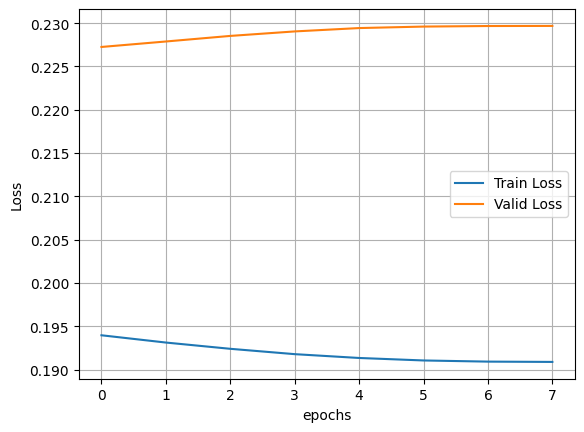

In [ ]:
plt.plot( range(len(history["Train Loss"])), history["Train Loss"], label="Train Loss")
plt.plot( range(len(history["Valid Loss"])), history["Valid Loss"], label="Valid Loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

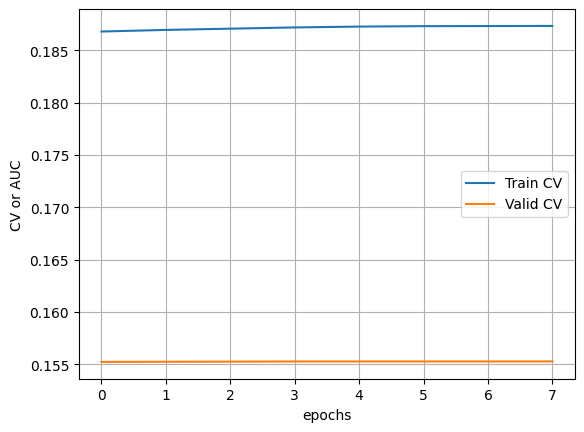

In [ ]:
plt.plot( range(len(history["Train CV"])), history["Train CV"], label="Train CV")
plt.plot( range(len(history["Valid CV"])), history["Valid CV"], label="Valid CV")
plt.xlabel("epochs")
plt.ylabel("CV or AUC")
plt.grid()
plt.legend()
plt.show()

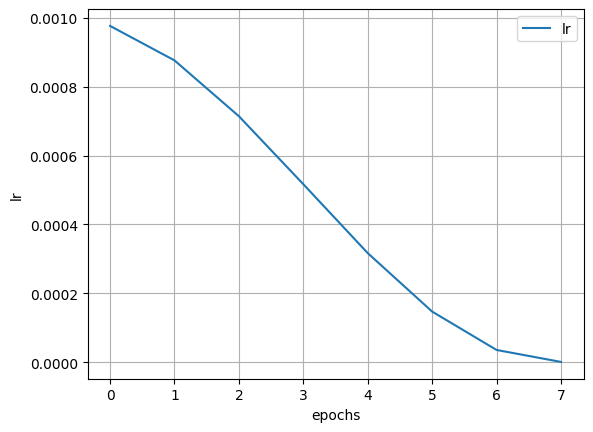

In [ ]:
plt.plot( range(len(history["lr"])), history["lr"], label="lr")
plt.xlabel("epochs")
plt.ylabel("lr")
plt.grid()
plt.legend()
plt.show()